# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


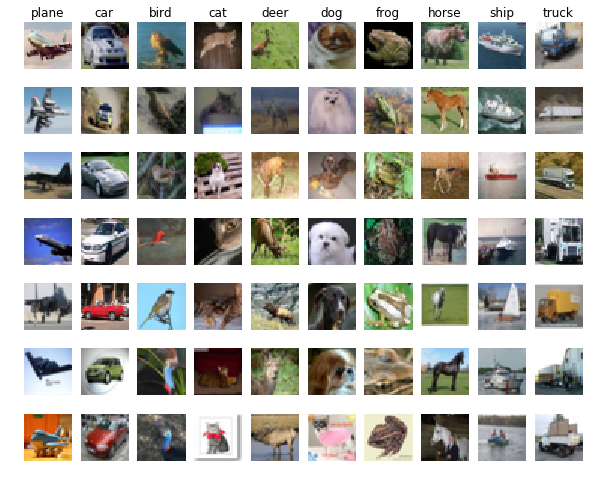

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


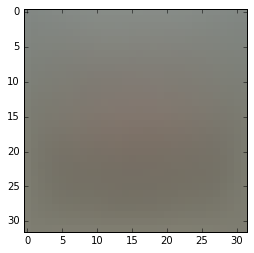

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )
print grad

loss: 8.562170
[[ -2.55764906e+00  -1.99224351e+00  -6.05667502e+00 ...,  -1.53404870e+01
   -1.36942023e+01  -2.63371209e+01]
 [ -1.12887580e+01   3.66880367e+00  -9.48997265e+00 ...,  -1.59943927e+01
   -2.73271325e+01  -3.23723014e+01]
 [ -2.53462264e+01   3.86314759e+00  -6.65481682e+00 ...,  -1.45077048e+01
   -4.85386171e+01  -4.45682863e+01]
 ..., 
 [  4.10938678e+00  -4.94792621e+00  -2.05129084e+01 ...,  -1.37958524e+01
    2.27874415e+01   9.74606856e-01]
 [ -3.73917086e+00  -1.32215811e+01  -1.34908463e+01 ...,  -2.23916229e+00
   -1.29722657e+00  -4.00165400e+00]
 [  6.79999977e-02   4.40000001e-02  -1.08000000e-01 ...,   8.79999996e-02
   -6.19999999e-02  -1.25999999e-01]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.315804 analytic: 1.315804, relative error: 4.231420e-10
numerical: -7.011293 analytic: -7.011293, relative error: 3.429003e-11
numerical: -10.398575 analytic: -10.398575, relative error: 1.107309e-11
numerical: 10.556781 analytic: 10.556781, relative error: 7.161692e-12
numerical: 4.846333 analytic: 4.846333, relative error: 2.881910e-11
numerical: 8.441930 analytic: 8.485459, relative error: 2.571485e-03
numerical: 36.039044 analytic: 36.039044, relative error: 3.935297e-13
numerical: 20.835319 analytic: 20.836557, relative error: 2.971613e-05
numerical: -21.065860 analytic: -21.065860, relative error: 2.959771e-14
numerical: -11.570638 analytic: -11.570638, relative error: 1.748402e-11
numerical: 22.962549 analytic: 22.962549, relative error: 4.382999e-12
numerical: 10.512792 analytic: 10.448124, relative error: 3.085159e-03
numerical: 1.061777 analytic: 1.061777, relative error: 2.830236e-10
numerical: -12.267827 analytic: -12.234974, relative error: 1.340772e-03
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [14]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized
svm_loss_vectorized(W, X_dev, y_dev, 0.00001)

(8.5621699064437777,
 array([[ -4.16148562e-01,  -3.24152865e-01,  -9.85466160e-01, ...,
          -2.49601156e+00,  -2.22814877e+00,  -4.28524583e+00],
        [ -1.83676504e+00,   5.96941698e-01,  -1.54408927e+00, ...,
          -2.60240687e+00,  -4.44632809e+00,  -5.26721468e+00],
        [ -4.12401992e+00,   6.28562901e-01,  -1.08278829e+00, ...,
          -2.36051169e+00,  -7.89759471e+00,  -7.25159230e+00],
        ..., 
        [  6.68627852e-01,  -8.05064465e-01,  -3.33760306e+00, ...,
          -2.24468799e+00,   3.70768654e+00,   1.58575798e-01],
        [ -6.08390963e-01,  -2.15124978e+00,  -2.19506122e+00, ...,
          -3.64328390e-01,  -2.11068430e-01,  -6.51098926e-01],
        [  1.10641067e-02,   7.15912789e-03,  -1.75724048e-02, ...,
           1.43182558e-02,  -1.00878620e-02,  -2.05011390e-02]]))

In [75]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)


# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 8.562170e+00 computed in 0.106270s
Vectorized loss: 8.562170e+00 computed in 0.010888s
difference: -0.000000


In [81]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.113479s
Vectorized loss and gradient: computed in 0.011093s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [84]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 785.071235
iteration 100 / 1500: loss 287.751075
iteration 200 / 1500: loss 107.697810
iteration 300 / 1500: loss 42.244005
iteration 400 / 1500: loss 18.390929
iteration 500 / 1500: loss 10.122483
iteration 600 / 1500: loss 6.970996
iteration 700 / 1500: loss 5.906107
iteration 800 / 1500: loss 5.024831
iteration 900 / 1500: loss 5.630709
iteration 1000 / 1500: loss 5.451430
iteration 1100 / 1500: loss 5.634190
iteration 1200 / 1500: loss 5.796671
iteration 1300 / 1500: loss 4.844160
iteration 1400 / 1500: loss 5.492161
That took 16.371962s


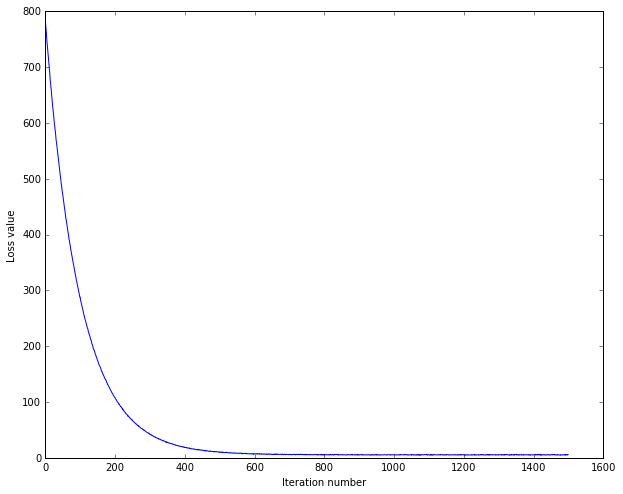

In [85]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [93]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

(49000,)
training accuracy: 0.360714
(1000,)
validation accuracy: 0.351000


In [112]:
import sys
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# learning_rates = [1e-7, 5e-5]
# regularization_strengths = [5e4, 1e5]
learning_rates = np.linspace(8.83e-8,9e-8,10)
regularization_strengths = np.linspace(4e4, 3.8e4,10)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for i in range(10):
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate=learning_rates[i], reg=regularization_strengths[i],
                      num_iters=1500, verbose=True)
    results[(learning_rates[i],regularization_strengths[i])] = None 
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (train_acc, )
    y_val_pred = svm.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (val_acc, )
    results[(learning_rates[i],regularization_strengths[i])] = (train_acc,val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
        svm = None
    print "------------------------------------------------------------------------------------"

    
#pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
#Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 636.838075
iteration 100 / 1500: loss 309.144416
iteration 200 / 1500: loss 153.817516
iteration 300 / 1500: loss 77.424487
iteration 400 / 1500: loss 41.212868
iteration 500 / 1500: loss 22.062003
iteration 600 / 1500: loss 13.893900
iteration 700 / 1500: loss 9.628599
iteration 800 / 1500: loss 6.698662
iteration 900 / 1500: loss 6.636760
iteration 1000 / 1500: loss 5.025774
iteration 1100 / 1500: loss 5.599762
iteration 1200 / 1500: loss 5.520907
iteration 1300 / 1500: loss 5.550802
iteration 1400 / 1500: loss 5.370378
(49000, 10)
(49000,)
training accuracy: 0.372490
(1000, 10)
(1000,)
validation accuracy: 0.376000
------------------------------------------------------------------------------------
iteration 0 / 1500: loss 638.958890
iteration 100 / 1500: loss 313.060409
iteration 200 / 1500: loss 155.915361
iteration 300 / 1500: loss 78.695999
iteration 400 / 1500: loss 41.146911
iteration 500 / 1500: loss 23.246485
iteration 600 / 1500: loss 13.602770
iter

In [113]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
print results

lr 8.830000e-08 reg 4.000000e+04 train accuracy: 0.372490 val accuracy: 0.376000
lr 8.848889e-08 reg 3.977778e+04 train accuracy: 0.375265 val accuracy: 0.392000
lr 8.867778e-08 reg 3.955556e+04 train accuracy: 0.371939 val accuracy: 0.383000
lr 8.886667e-08 reg 3.933333e+04 train accuracy: 0.373633 val accuracy: 0.380000
lr 8.905556e-08 reg 3.911111e+04 train accuracy: 0.377980 val accuracy: 0.401000
lr 8.924444e-08 reg 3.888889e+04 train accuracy: 0.371347 val accuracy: 0.371000
lr 8.943333e-08 reg 3.866667e+04 train accuracy: 0.376000 val accuracy: 0.378000
lr 8.962222e-08 reg 3.844444e+04 train accuracy: 0.372122 val accuracy: 0.383000
lr 8.981111e-08 reg 3.822222e+04 train accuracy: 0.374490 val accuracy: 0.392000
lr 9.000000e-08 reg 3.800000e+04 train accuracy: 0.373796 val accuracy: 0.391000
best validation accuracy achieved during cross-validation: 0.401000
{(8.9433333333333333e-08, 38666.666666666664): (0.376, 0.378), (8.9055555555555557e-08, 39111.111111111109): (0.3779795918

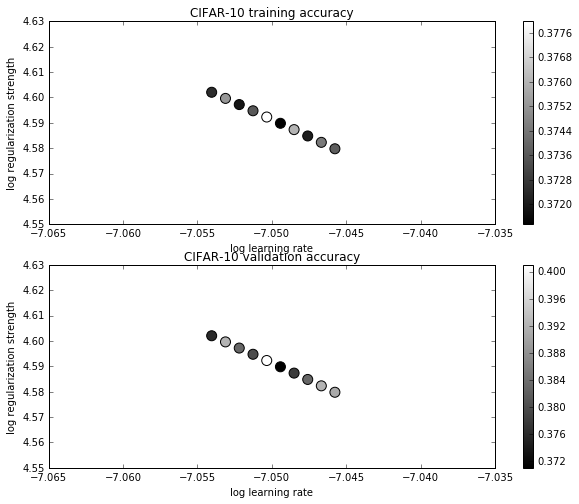

In [114]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [115]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

(1000, 10)
(1000,)
linear SVM on raw pixels final test set accuracy: 0.382000


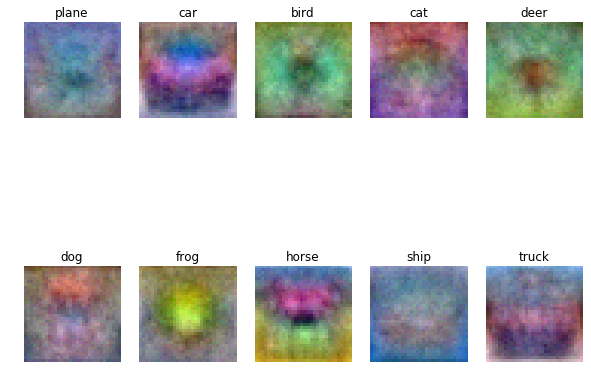

In [116]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

In [68]:
a = np.random.randint(0,100,5000).reshape((500,10))
b = np.random.randint(0,10,10)

In [70]:
a[[0,1],[3,4]]

array([81, 64])

In [97]:
learning_rates = np.linspace(1e-7,1e-10,10)
regularization_strengths = np.linspace(5e4, 1e4,10)
print learning_rates,regularization_strengths

[  1.00000000e-07   8.89000000e-08   7.78000000e-08   6.67000000e-08
   5.56000000e-08   4.45000000e-08   3.34000000e-08   2.23000000e-08
   1.12000000e-08   1.00000000e-10] [ 50000.          45555.55555556  41111.11111111  36666.66666667
  32222.22222222  27777.77777778  23333.33333333  18888.88888889
  14444.44444444  10000.        ]


In [26]:
a

NameError: name 'a' is not defined